<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Newton's divided differences, Sinc interpolation and piecewise-linear interpolations. </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.01</h2>
</center>

<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [Newton's divided differences](#NewtonDD)
* [Sinc interpolator](#SincInterpolator)
* [Piecewise linear interpolator](#PiecewiseLinearInterpolator)
* [Convergence analysis](#convergence)
* [Analysis of time vs error for interpolation algorithms](#AnalysisTimeVsError)
* [Acknowledgements](#acknowledgements)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from functools import reduce
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
%matplotlib inline
from ipywidgets import interact, fixed, IntSlider, interact_manual, Checkbox, RadioButtons
sym.init_printing()
import time

<div id='intro' />

##  Introduction
[Back to TOC](#toc)

In this Bonus jupyter notebook we add the Newton divided differences algorithm, Sinc interpolation and piecewise linear interpolation for comparison purposes.

In [2]:
# Function that evaluates the xi's points in the polynomial
def EvaluateInterpolant(D, xx):
    if D['Method']=='Vandermonde':
        p = lambda x: np.dot(D['PrecomputedData'],np.power(x,np.arange(D['n'])))
    elif D['Method']=='Lagrange':
        p = lambda x: np.dot(D['PrecomputedData'],[np.prod(x - np.delete(D['x'],j)) for j in range(D['n'])])
    elif D['Method']=='Barycentric':
        wi = D['PrecomputedData']
        xi = D['x']
        yi = D['y']
        p = lambda x: np.sum(yi*wi/(x-xi))/np.sum(wi/(x-xi)) if len(xi[xi == x])==0 else np.ndarray.item(yi[xi == x])
    elif D['Method']=='Newton':
        p = lambda x: np.dot(D['PrecomputedData'],np.append([1],[np.prod(x-D['x'][:j]) for j in range(1,D['n'])]))
    elif D['Method']=='SincInterpolator':
        p = lambda x: np.dot([np.sinc((x-xi)/D['h']) for xi in D['x']],D['y'])
    elif D['Method']=='PiecewiseLinear':
        m = D['m']
        n = D['n']
        xi = D['x']
        yi = D['y']
        def p(x):
            for i in range(n-1):
                if xi[i]<= x and x<xi[i+1]:
                    return yi[i]+m[i]*(x-xi[i])
            # This is the last case, if x==x[-1]
            return yi[-1]
    return np.array([p(x) for x in xx])
    
# Function that shows the data points and the function that interpolates them.
def PlotInterpolant(D,ylim=None):
    xi = np.linspace(min(D['x']),max(D['x']),1000)
    yi = EvaluateInterpolant(D,xi)
    fig = plt.figure(figsize=(8,8))
    plt.plot(D['x'],D['y'],'ro',label='Interpolation points')
    plt.plot(xi,yi,'b-',label='$p(x)$')
    plt.xlim(min(xi)-0.5, max(xi)+0.5)
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    else:
        plt.ylim(min(yi)-0.5, max(yi)+0.5)
    plt.grid(True)
    plt.legend(loc='best')
    plt.xlabel('$x$')
    plt.show()

## We repeat the already presented algorithms.
[Back to TOC](#toc)

In [3]:
def Vandermonde(x, y, show=False):
    # We construct the matrix and solve the system of linear equations
    # A = np.array([xi**np.arange(len(x)) for xi in x]) # OLDER VERSION
    A = np.vander(x, increasing=True)
    b = y
    coefficients = np.linalg.solve(A,b)
    n = len(x)
    
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(n)])
        print('A = '); print(np.array_str(A, precision=2, suppress_small=True))
        print("cond(A) = "+str(np.linalg.cond(A)))
        print('b = '); print(np.array_str(b, precision=2, suppress_small=True))
        print('x = '); print(np.array_str(coefficients, precision=2, suppress_small=True))
        xS = sym.Symbol('x')
        F = np.dot(xS**np.arange(len(x)),coefficients)
        print('Interpolation Function: ') 
        print('F(x) = ')
        print(F)
        
    # Finally, we return a data structure with our interpolating polynomial
    D = {'Method': 'Vandermonde',
         'PrecomputedData': coefficients,
         'x': x,
         'y': y,
         'n': n}
    return D

In [4]:
def Lagrange(x, y, show=False):
    # We calculate the li's
    n = len(x)
    p = np.array([y[i]/np.prod(x[i] - np.delete(x,i)) for i in range(n)])
    
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(n)])
        xS = sym.Symbol('x')
        L = np.dot(np.array([np.prod(xS - np.delete(x,i))/np.prod(x[i] - np.delete(x,i)) for i in range(n)]),y)
        print('Interpolation Function: '); 
        print(L)
        
    # Finally, we return a data structure with our interpolating polynomial        
    D = {'Method': 'Lagrange',
         'PrecomputedData': p,
         'x': x,
         'y': y,
         'n': n}
    return D

In [5]:
def Barycentric(x, y, show=False):
    W  = np.subtract.outer(x, x)
    wi  = 1/np.prod(W, axis=1, where = W!=0)
    n = len(x)

    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(n)])
        xS = sym.Symbol('x')
        N = np.sum(y*wi/(xS-x))/np.sum(wi/(xS-x))
        print('Interpolation Function: ');
        print(N)
    
    # Finally, we return a data structure with our interpolating polynomial
    D = {'Method':'Barycentric',
         'PrecomputedData': wi,
         'x': x,
         'y': y,
         'n': n}
    return D

<div id='NewtonDD' />

## Newton's Divided Difference
[Back to TOC](#toc)

In this interpolation method we will use divided differences to calculate the coefficients of our interpolation polynomial. Given a set of $n$ data points $(x_1,y_1),...,(x_n,y_n)$, the Newton polynomial is:
$$ p(x) = \sum^n_{i=1} (f[x_1 ... x_i] \cdot \prod^{i-1}_{j=1} (x-x_j)) ,$$
where $ \prod^{0}_{j=1} (x-x_j) = 0 $, and:
$$ f[x_i] = y_i $$ 
$$ f[x_j...x_i] = \frac{f[x_{j+1}...x_i]-f[x_j...x_{i-1}]}{x_i-x_j}$$

In [6]:
def Divided_Differences(x, y):
    dd = np.array([y])
    n = len(x)
    for i in range(n-1):
        ddi = []
        for a in range(n-i-1):
            ddi.append((dd[i][a+1]-dd[i][a])/(x[a+i+1]-x[a]))
        ddi = np.append(ddi,np.full((n-len(ddi),),0.0))
        dd = np.append(dd,[ddi],axis=0)
    return np.array(dd)
    
def NewtonDD(x, y, show=False):
    # We calculate the divided differences and store them in a data structure
    dd = Divided_Differences(x,y)
    n = len(x)
    
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(n)])
        xS = sym.Symbol('x')
        N = np.dot(dd[:,0],np.append([1],[np.prod(xS-x[:i]) for i in range(1,n)]))
        print('Interpolation Function: ');
        print(N)
        
    # Finally, we return a data structure with our interpolating polynomial
    D = {'Method':'Newton',
         'PrecomputedData': dd[:,0],
         'x': x,
         'y': y,
         'n': n}
    return D

Data Points: 
[(0.0, 0.0), (0.16666666666666666, 0.919444979253755), (0.3333333333333333, 0.7230858817383248), (0.5, -0.35078322768961984), (0.6666666666666666, -0.9989549170979283), (0.8333333333333333, -0.43483223962507717), (1.0, 0.6569865987187891)]
Interpolation Function: 
40.6256591455599*x*(x - 0.833333333333333)*(x - 0.666666666666667)*(x - 0.5)*(x - 0.333333333333333)*(x - 0.166666666666667) - 102.482745619068*x*(x - 0.666666666666667)*(x - 0.5)*(x - 0.333333333333333)*(x - 0.166666666666667) + 57.5053218220759*x*(x - 0.5)*(x - 0.333333333333333)*(x - 0.166666666666667) + 8.57858633484017*x*(x - 0.333333333333333)*(x - 0.166666666666667) - 20.0844733818453*x*(x - 0.166666666666667) + 5.51666987552253*x


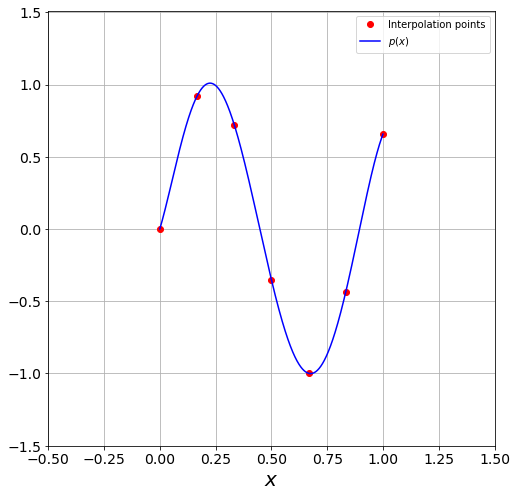

In [7]:
x = np.linspace(0,1,7)
y = np.sin(7*x)
D = NewtonDD(x, y, show=True)
PlotInterpolant(D,ylim=None)

Questions about Newton's DD:
- What is the main problem using this method (and Lagrange)? How can you fix it? **A: A problem with polynomial interpolation with equispaced date is the Runge phenomenon and can be handle with Chebyshev points**
- What to do when a new point is added? **A: Pro, is not necessary re-calculate the whole polynomial only a small piece**

<div id='SincInterpolator' />

## Sinc interpolator
[Back to TOC](#toc)

The Sinc interpolator is not a polynomial interpolator but it is an interesting one to know.
It is useful for equalspaced data $x_i$ and if has the following form:
$$
g(x)=\sum_{i=1}^n y_i\,\text{sinc}\left(\frac{x-x_i}{h}\right),
$$
where $h=x_{i+1}-x_{i}$ and $\text{sinc}(x)=\dfrac{\sin(\pi\,x)}{\pi\,x}$.

In [8]:
def SincInterpolator(x, y, show=False):
    # We first check the data in equalspaced
    dx = np.diff(x)
    if np.abs(np.max(dx)-np.min(dx))>1e-10:
        raise ValueError("SincInterpolator: Data not equalspaced")
    
    # Computing h = x[i+1]-x[i]
    h = dx[0]
    n = len(x)
        
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); 
        print([(x[i],y[i]) for i in range(n)])
        xS = sym.Symbol('x')
        SI = np.dot([sym.sinc((xS-xi)/h) for xi in x],y)
        print('Interpolation Function: '); 
        print(SI)
        
    # Finally, we return a data structure with our interpolating polynomial        
    D = {'Method': 'SincInterpolator',
         'h': h,
         'x': x,
         'y': y}
    return D

Data Points: 
[(0.0, 0.0), (0.16666666666666666, 0.919444979253755), (0.3333333333333333, 0.7230858817383248), (0.5, -0.35078322768961984), (0.6666666666666666, -0.9989549170979283), (0.8333333333333333, -0.43483223962507717), (1.0, 0.6569865987187891)]
Interpolation Function: 
0.656986598718789*sinc(6.0*x - 6.0) - 0.434832239625077*sinc(6.0*x - 5.0) - 0.998954917097928*sinc(6.0*x - 4.0) - 0.35078322768962*sinc(6.0*x - 3.0) + 0.723085881738325*sinc(6.0*x - 2.0) + 0.919444979253755*sinc(6.0*x - 1.0)


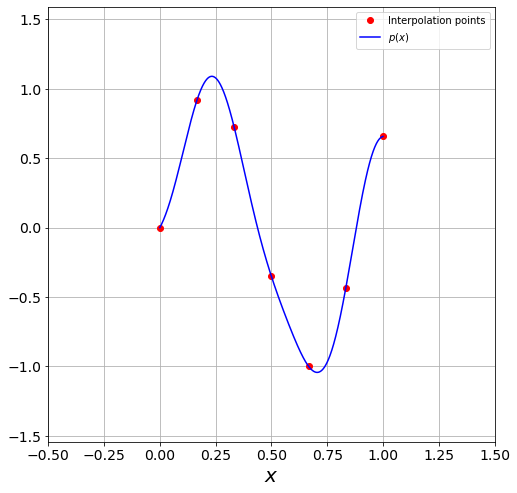

In [9]:
D = SincInterpolator(x, y, show=True)
PlotInterpolant(D,ylim=None)

<div id='PiecewiseLinearInterpolator' />

## Piecewise linear interpolator
[Back to TOC](#toc)

This interpolator interpolates the data between datapoints $(x_i,y_i)$ and $(x_{i+1},y_{i+1})$ with a linear function of the form $y_i+\frac{y_{i+1}-y_i}{x_{i+1}-x_i}(x-x_i)$.
The general form is the following:
$$
    g(x)=
        \begin{cases}
            y_1+\frac{y_2-y_1}{x_2-x_1}(x-x_1), \quad x \in [x_1,x_2]\\
            y_2+\frac{y_3-y_2}{x_3-x_2}(x-x_2), \quad x \in ]x_2,x_3]\\
            \quad \vdots\\
            y_i+\frac{y_{i+1}-y_i}{x_{i+1}-x_i}(x-x_i), \quad x \in ]x_i,x_{i+1}]\\
            \quad \vdots\\
            y_{n-1}+\frac{y_n-y_{n-1}}{x_n-x_{n-1}}(x-x_{n-1}), \quad x \in ]x_{n-1}, x_n]
        \end{cases}.
$$
In this case we don't requiere that the date is equalspaced.

In [10]:
def PiecewiseLinear(x, y, show=False):
    # Precomputing slopes for linear interpolation
    ii = np.argsort(x)
    x = x[ii]
    y = y[ii]
    n = len(x)
    m = np.diff(y)/np.diff(x)
        
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); 
        print([(x[i],y[i]) for i in range(n)])
        xS = sym.Symbol('x')
        PL = []
        for i in np.arange(len(m)):
            PL.append([[x[i],x[i+1]], y[i]+ m[i]*(xS-x[i])])
        print('Interpolation Functions: '); 
        print(PL)
        
    # Finally, we return a data structure with our interpolating polynomial        
    D = {'Method': 'PiecewiseLinear',
         'm': m,
         'n': n,
         'x': x,
         'y': y}
    return D

Data Points: 
[(0.0, 0.0), (0.16666666666666666, 0.919444979253755), (0.3333333333333333, 0.7230858817383248), (0.5, -0.35078322768961984), (0.6666666666666666, -0.9989549170979283), (0.8333333333333333, -0.43483223962507717), (1.0, 0.6569865987187891)]
Interpolation Functions: 
[[[0.0, 0.16666666666666666], 5.51666987552253*x], [[0.16666666666666666, 0.3333333333333333], 1.11580407676919 - 1.17815458509258*x], [[0.3333333333333333, 0.5], 2.87082410059421 - 6.44321465656767*x], [[0.5, 0.6666666666666666], 1.59373184053531 - 3.88903013644985*x], [[0.6666666666666666, 0.8333333333333333], 3.38473606483711*x - 3.25544562698933], [[0.8333333333333333, 1.0], 6.5509130300632*x - 5.89392643134441]]


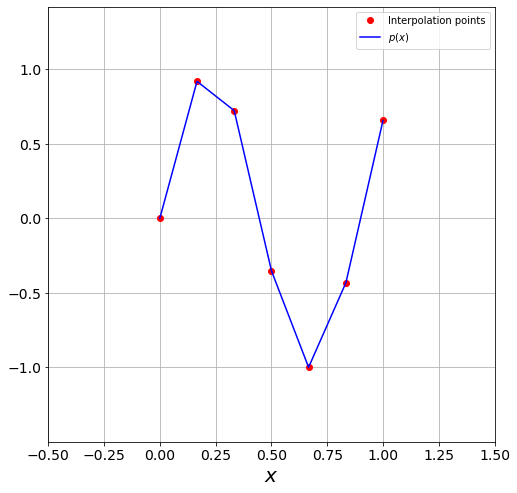

In [11]:
D = PiecewiseLinear(x, y, show=True)
PlotInterpolant(D,ylim=None)

In [12]:
def show_time_new_algorithms(i=0, N=7, method='NewtonDD'):
    x = np.arange(N+1)
    y = np.zeros(N+1)
    y[i]=1
    D = method(x,y,True)
    PlotInterpolant(D,[-1,2])

i_widget = IntSlider(min=0, max=7, step=1, value=0)
N_widget = IntSlider(min=1, max=20, step=1, value=7)
def update_i_range(*args):
    i_widget.max = N_widget.value
N_widget.observe(update_i_range, 'value')

radio_button_interpolation_algorithm=RadioButtons(
    options=[('NewtonDD',NewtonDD),('SincInterpolator',SincInterpolator),('PiecewiseLinear',PiecewiseLinear)],
    value=SincInterpolator,
    description='New Alg.:',
    disabled=False
)

interact(show_time_new_algorithms,i=i_widget,N=N_widget,method=radio_button_interpolation_algorithm)

interactive(children=(IntSlider(value=0, description='i', max=7), IntSlider(value=7, description='N', max=20, …

<function __main__.show_time_new_algorithms(i=0, N=7, method='NewtonDD')>

## Another set of previous definitions
[Back to TOC](#toc)

In [13]:
def Chebyshev(xmin,xmax,n=5):
    # This function calculates the n Chebyshev points and plots or returns them depending on ax
    ns = np.arange(1,n+1)
    x = np.cos((2*ns-1)*np.pi/(2*n))
    y = np.sin((2*ns-1)*np.pi/(2*n))
    plt.figure(figsize=(10,5))
    plt.ylim(-0.1,1.1)
    plt.xlim(-1.1,1.1)
    plt.plot(np.cos(np.linspace(0,np.pi)),np.sin(np.linspace(0,np.pi)),'k-')
    plt.plot([-2,2],[0,0],'k-')
    plt.plot([0,0],[-1,2],'k-')
    for i in range(len(y)):
        plt.plot([x[i],x[i]],[0,y[i]],'r-')
        plt.plot([0,x[i]],[0,y[i]],'r-')
    plt.plot(x,[0]*len(x),'bo',label='Chebyshev points')
    plt.plot(x,y,'ro')
    plt.xlabel('$x$')
    plt.title('n = '+str(n))
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()
def Chebyshev_points(xmin,xmax,n):
    ns = np.arange(1,n+1)
    x = np.cos((2*ns-1)*np.pi/(2*n))
    #y = np.sin((2*ns-1)*np.pi/(2*n))
    return (xmin+xmax)/2 + (xmax-xmin)*x/2

In [14]:
def Error(f, n, xmin, xmax, method=Lagrange, points=np.linspace, plot_flag=True):
    # This function plots f(x), the interpolating polynomial, and the associated error
    # points can be np.linspace to equidistant points or Chebyshev to get Chebyshev points
    
    # These two lines generate the data that will be used in the interpolation
    x = points(xmin,xmax,n)
    y = f(x)
    
    # These two lines compute the exact value of the function being interpolated on a finer grid
    xe = np.linspace(xmin,xmax,200)
    ye = f(xe)
    
    # This two lines build the interpolant chosen, where the name of the method is 
    # passed as parameter usign the variable 'method'.
    D = method(x,y)
    yi = EvaluateInterpolant(D, xe)
    
    if plot_flag:
        plt.figure(figsize=(5,10))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey = False)

        ax1.plot(xe, ye,'k-', label='f(x)')
        ax1.plot(x, y,'ro', label='Interpolation points',markersize=10)
        ax1.plot(xe, yi,'b-', label='Interpolation')
        ax1.set_xlim(xmin-0.5,xmax+0.5)
        ax1.set_ylim(min(yi)-0.5,max(yi)+0.5)       
        ax1.set_title('Interpolation')
        ax1.grid(True)
        ax1.set_xlabel('$x$')
        ax1.legend(loc='best') 

        ax2.semilogy(xe, abs(ye-yi),'c-', label='Absolute Error')
        ax2.set_xlim(xmin-0.5,xmax+0.5)
        ax2.set_title('Absolute Error')
        ax2.set_xlabel('$x$')
        ax2.grid(True) 
        plt.show()
        
    return max(abs(ye-yi))

<div id='convergence' />

## Convergence analysis
[Back to TOC](#toc)

The next set of experiments show a convergence analysis comparing equalspaced points to Chebychev points.
The $x$-axis is the number of points used and the $y$-axis is the maxmimum error obtain on the interval in logarithmic scale.
The experiment are the followings:
1. $f(x)=x^{10}$. In this case both sets of points perform similarly, however there is a significant drop in the error when $n$ is equal to $11$. This means, the error reach a minimum of $10^{-14}$ app at that number points. Why?
2. $f(x)=|x^3|$. This looks like a naive function but it is not. The equalspace points start to decrease from an error of $10^{0}$ until an error app $10^{-3}$ with approximately 10 points, it then start to increase the error. On the other hand, the Chebychev points show a decresing behavior upto $n=50$ but it only reaches an error of app $10^{-5}$, which is too high. What is the issue with this funcion?
3. $f(x)=\exp(-(x^{-2}))$. This is also a tricky function bevcause involves a division by $0$ when we evaluate it at $x=0$, but it is well defined at that points. Similarly to the first example, the equalspaced points reduce the error upto $n=10$, and then start to increase. For the Chebychev points, they decrease upto 40 points and the also show a slight increment in the error. What is the value of $f(x)$ at $x=0$?
4. $f(x)=\dfrac{1}{1+x^2}$. In this case both cases decrease the error but faster for the Chebyshev points. The main difference is that the minimum error reached for equalspaced points is about $10^{-8}$ and $10^{-13}$ for the Chebyshev points, in both cases about $n=37$.
5. $f(x)=\sin^3(x)$. In this case both cases reached an error $10^{-14}$ with $n=20$, then for equalspaced points start to increase the error right away but for Chebyshev points it starts to increase at $n=40$.

Answers to the previous questions:
1. The reason is that when $n=11$ we will be interpolation an polynomial of degree $10$ with a polynomial of degree $10$, so we can reproduce it exactly! This is why the error is $0$. When $n$ was lower, we only had an approximation. It is interesting that the error increases as we increase the number of points after $n=10$. Would it be useful to change the algorihtm used?
2. The issue is that the function is not analytic, this is because it involves the absolute value. Recall that expression for the error requires the computation of the $n$-th derivative of $f(x)$ at a $c$ point, so if the function is not differentiable, in this case the issues is at $x=0$, we could expect a bad behavior. The probles can be easily solve if we interpolate the function with a polynomial defined on $[-1,0]$ and another on $[0,1]$, ensurring the are equal at $x=0$. In this case we only need two polynomials of degree $3$ and we will be able to reproduce the function exactly! The issue is to notice this when we only have access to the computational implementation of $f(x)$ and not to the function itself.
3. 0
4. -
5. -

**We strongly suggest you to try different functions and play around!**

In [15]:
my_functions=[lambda x: x**10,
              lambda x: np.abs(x**3),
              lambda x: np.exp(-(x**-2)),
              lambda x: 1/(1+x**2),
              lambda x: np.sin(x)**3]
labels = ["x^{10}",
          "|x^3|",
          "\exp(-x^{-2})",
          "1/(1+x^2)",
          "\sin^3(x)"]
data=zip(labels,my_functions)

radio_button_function=RadioButtons(
    options=list(data),
    description='Function:',
    disabled=False
)

radio_button_interpolation_algorithm=RadioButtons(
    options=[('Vandermonde',Vandermonde),('Lagrange',Lagrange),('Barycentric',Barycentric),('NewtonDD',NewtonDD),('SincInterpolator',SincInterpolator),('PiecewiseLinear',PiecewiseLinear)],
    value=Barycentric,
    description='Algorithm:',
    disabled=False
)

def convergence_study(my_function, method):
    n=100
    shift=2
    n_points=np.arange(shift,n)
    max_error=np.zeros(n-shift)
    max_error_es=np.zeros(n-shift)
    for i in n_points:
        if method!=SincInterpolator:
            max_error[i-shift] = Error(my_function, i, -1, 1, method, Chebyshev_points, plot_flag=False)
        else:
            max_error[i-shift] = 1
        max_error_es[i-shift] = Error(my_function, i, -1, 1, method, points=np.linspace, plot_flag=False)
    axis=plt.figure(figsize=(8,8))
    if method!=SincInterpolator:
        plt.semilogy(n_points,max_error,'bd',label='Chebyshev points',markersize=10)
    plt.semilogy(n_points,max_error_es,'r.',label='Equalspaced poins',markersize=16)
    plt.ylim(10**-16,10**4)
    plt.grid(True)
    plt.title('Interpolation Error')
    plt.xlabel('Number of points used in the interpolation')
    plt.ylabel('Max error on domain')
    plt.legend(loc='best')
    plt.show()
interact(convergence_study,my_function=radio_button_function, method=radio_button_interpolation_algorithm)

interactive(children=(RadioButtons(description='Function:', options=(('x^{10}', <function <lambda> at 0x7fe9b1…

<function __main__.convergence_study(my_function, method)>

<div id='AnalysisTimeVsError' />

## Analysis of time vs error for interpolation algorithms
[Back to TOC](#toc)

The idea here is to understand the relationship between the error we get for each algorithm and the computation time associated.
This analysis highlights the advantage of Barycentric interpolation with Chebyshev points when the function being interpolated is analytic.
Notice that the first plot shows the computation time required for the construction of the interpolant, the second the cost of evaluation of the interpolant in a finer grid and the third one shows the sum of both times.

In [16]:
def get_error_and_time(f, xmin=-1, xmax=1, method=Lagrange, points=np.linspace):
    
    construction_times   = []
    evaluation_times     = []
    interpolation_errors = []
    
    #n_range = np.logspace(1, 2, num=5, endpoint=True, base=10, dtype=int)
    n_range = np.array([2,4,8,16,30,50])
    
    for n in n_range:
        
        # This function plots f(x), the interpolating polynomial, and the associated error
        # points can be np.linspace to equidistant points or Chebyshev to get Chebyshev points

        # These two lines generate the data that will be used in the interpolation
        x = points(xmin,xmax,n)
        y = f(x)

        # These two lines compute the exact value of the function being interpolated on a finer grid
        xe = np.linspace(xmin,xmax,100)
        ye = f(xe)

        # This two lines build the interpolant chosen, where the name of the method is 
        # passed as parameter usign the variable 'method'.
        time_construction = %timeit -o -q -n 10 -r 5 method(x,y)
        construction_times.append(time_construction.average)
        D = method(x,y)
        
        time_evaluation = %timeit -o -q -n 10 -r 5 EvaluateInterpolant(D, xe)
        evaluation_times.append(time_evaluation.average)
        yi = EvaluateInterpolant(D, xe)
        
        if max(abs(ye-yi))<1e-16:
            interpolation_errors.append(1e-16)
        else:
            interpolation_errors.append(max(abs(ye-yi)))
        
    return construction_times, evaluation_times, interpolation_errors


def analysis_error_vs_time_interpolation_algorihtms(f):
    # List of methods
    list_of_methods = [('Vandermonde',Vandermonde),('Lagrange',Lagrange),('Barycentric',Barycentric),('NewtonDD',NewtonDD),('SincInterpolator',SincInterpolator),('PiecewiseLinear',PiecewiseLinear)]
    # List of type of points
    list_of_points = [('equalspaced',np.linspace), ('Chebyshev',Chebyshev_points)]
    list_output_data = []
    k = 1
    for name_method, method in list_of_methods:
        for points_name, points in list_of_points:
            # We exclude SincInterpolator for Chebyshev points because it need equalspaced data
            if (name_method=='SincInterpolator' and points_name=='Chebyshev'):
                continue
            tic = time.time()
            c_time, e_time, errors = get_error_and_time(f, xmin=-1, xmax=1, method=method, points=points)
            print(k,'/ 11: ',name_method, ',' , points_name, ', time:',time.time()-tic,'[s]')
            k=k+1
            list_output_data.append([name_method, points_name, c_time, e_time, errors])
    
    markers = ['8','>','<','^','v','o','d','D','H','h','*','p','s']
    
    fig = plt.figure(figsize=(16,16))
    plt.rcParams.update({'font.size': 12})
    
    k = 0
    for data in list_output_data:
        name_method, points_name, c_time, e_time, errors = data
            
        ax = plt.subplot(2,2,1)
        plt.title('Construction time')
        plt.loglog(errors, c_time, markers[k], lw=2.0, ms=10, label=name_method+', '+points_name)
        ax = plt.subplot(2,2,2)
        plt.title('Evaluation time')
        plt.loglog(errors, e_time, markers[k], lw=2.0, ms=10, label=name_method+', '+points_name)
        ax = plt.subplot(2,2,3)
        plt.title('Construction + evaluation times')
        plt.loglog(errors, np.array(c_time)+np.array(e_time), markers[k], lw=2.0, ms=10, label=name_method+', '+points_name)
        k=k+1
    
    plt.legend(loc='lower left', ncol=1, fancybox=True, shadow=True, numpoints=1, bbox_to_anchor=(1,0))
    
    for i in range(3):
        ax = plt.subplot(2,2,i+1)
        plt.xlabel("Absolute Error")
        plt.ylabel("Time in seconds")
        plt.grid('on')
    plt.show()

interact(analysis_error_vs_time_interpolation_algorihtms,f=radio_button_function)

interactive(children=(RadioButtons(description='Function:', options=(('x^{10}', <function <lambda> at 0x7fe9b1…

<function __main__.analysis_error_vs_time_interpolation_algorihtms(f)>

**Warning**: Notice that this experiment shows a _competitive_ behavior of the Vandermonde matrix but don't forget that the Vandermonde matrix is very ill-conditioned!

<div id='py' />

## Python Modules and Functions
[Back to TOC](#toc)

Interpolation: 

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

Vandermonde Matrix: 

https://numpy.org/doc/stable/reference/generated/numpy.vander.html

Lagrange Interpolator: 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html

Barycentric Interpolator:

https://people.maths.ox.ac.uk/trefethen/barycentric.pdf

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BarycentricInterpolator.html

Chebyshev Points for the First Kind:

https://numpy.org/doc/stable/reference/generated/numpy.polynomial.chebyshev.chebroots.html

<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)

* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _. DI UTFSM. October 2021._
* _Update October 2021 - v1.01 - C.Torres_ : Re-organizing jupyter notebook. 